In [1]:
import sys

import torch
from torch.nn import functional
import torch.nn as nn
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Callable, NamedTuple, List
from collections import namedtuple
import random


In [3]:
torch.__version__, torchvision.__version__

('1.12.1+cu113', '0.13.1+cu113')

In [4]:
device = torch.device("cuda")

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

###Download data


In [7]:
%%capture
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip -O temp.zip
!unzip temp.zip

###Prepare resnet18

In [8]:
from torchvision.models import resnet18, ResNet18_Weights

In [9]:
model = resnet18(weights = "ResNet18_Weights.IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

###Freeze layers and create new fully_connected layer

In [10]:
#model

In [11]:
# for name, layer in model.named_modules():
#   print(name)

In [12]:
for name, param in model.named_parameters():
  if 'layer4.1' not in name:
    param.requires_grad = False

In [13]:
for name, par in model.named_parameters():
  if par.requires_grad:
       print(name)

layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias


(для себя)

In [14]:
# for name, child in model.named_children():
#   print(name)
#   if 'layer4.1' not in name:
#     for param in child.parameters():
#         param.requires_grad = False

In [15]:
# for name, child in model.named_children():
#   for param in child.parameters():
#         if param.requires_grad == True:
#           print(name)

In [16]:
# for name, layer in model.named_modules():
#   if 'layer4.1' not in name:
#     print(layer.trainable)

In [17]:
# for name, layer in model.named_modules():
#   if layer.trainable == True:
#     print(name)

In [18]:
model.fc = torch.nn.Linear(512, 2, bias = True)

###Prepare data

In [19]:
train_dataset = torchvision.datasets.ImageFolder('hymenoptera_data/train')

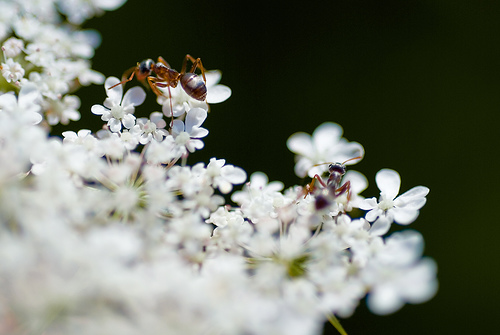

In [20]:
train_dataset[3][0]

In [21]:
weights = ResNet18_Weights.DEFAULT
transforms = weights.transforms()

In [22]:
train_dataset = torchvision.datasets.ImageFolder('hymenoptera_data/train', transform=transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=1)

In [23]:
train_dataset[3][0]

tensor([[[-1.7925, -1.7925, -1.7925,  ..., -1.9295, -1.9467, -1.9295],
         [-1.7925, -1.7925, -1.7925,  ..., -1.9467, -1.9467, -1.9467],
         [-1.7754, -1.7754, -1.7925,  ..., -1.9467, -1.9467, -1.9638],
         ...,
         [ 0.7933,  0.7933,  0.7762,  ..., -0.5596, -0.7993, -1.0733],
         [ 0.8618,  0.8618,  0.8447,  ..., -0.9877, -1.2617, -1.5014],
         [ 0.8961,  0.8961,  0.8961,  ..., -1.5014, -1.6898, -1.8097]],

        [[-1.5630, -1.5630, -1.5630,  ..., -1.7731, -1.7906, -1.7906],
         [-1.5630, -1.5630, -1.5630,  ..., -1.7731, -1.7906, -1.7731],
         [-1.5280, -1.5455, -1.5630,  ..., -1.7731, -1.7731, -1.7731],
         ...,
         [ 0.9580,  0.9580,  0.9405,  ..., -0.2675, -0.5126, -0.7927],
         [ 1.0105,  1.0105,  1.0105,  ..., -0.7402, -1.0203, -1.2479],
         [ 1.0455,  1.0455,  1.0630,  ..., -1.2479, -1.4580, -1.5805]],

        [[-1.7522, -1.7522, -1.7522,  ..., -1.7870, -1.7870, -1.7522],
         [-1.7522, -1.7522, -1.7522,  ..., -1

In [24]:
val_dataset = torchvision.datasets.ImageFolder('hymenoptera_data/val', transform=transforms)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=64,
                                          shuffle=False,
                                          num_workers=1)

###Create model, chose optimizer & criterion

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
model.to(device)

In [26]:
def train_epoch(
    model: torch.nn.Module, 
    optimizer: torch.optim.Optimizer, 
    loader: torch.utils.data.DataLoader, 
    criterion: torch.nn.modules.loss._Loss,
    device: torch.device,
    verbose: bool = False,
) -> float:
    model.train(True)
    model.to(device)
    optimizer.zero_grad()
    acc_loss = 0
    total = len(loader.dataset)
    if verbose:
        loader = tqdm(loader, desc="Training", total=len(loader), leave=True)
    for input_data, target in loader:
        input_data = input_data.to(device)
        target = target.to(device)
        predicted = model(input_data)
        
        loss = criterion(predicted, target)
        
        # calculate gradient
        loss.backward()
        # update weights
        optimizer.step()
        # flush gradients
        optimizer.zero_grad()
        acc_loss += loss.item()
        
    return acc_loss / total


EvalOutput = namedtuple("EvalOutput", ["loss", "accuracy"])


def eval_epoch(
    model: torch.nn.Module, 
    loader: torch.utils.data.DataLoader, 
    criterion: torch.nn.modules.loss._Loss,
    device: torch.device,
    verbose: bool = False,
) -> EvalOutput:
    model.train(False)
    model.to(device)
    acc_loss = 0
    acc = 0
    total = len(loader.dataset)

    # no grad for context manager to accelerate evaluation
    with torch.no_grad():
        if verbose:
            loader = tqdm(loader, desc="Evaluation", total=len(loader), leave=True)
        for input_data, target in loader:
            input_data = input_data.to(device)
            target = target.to(device)
            predicted = model(input_data)
            
            loss = criterion(predicted, target)
            acc_loss += loss.item()

            acc += torch.sum(
                torch.argmax(predicted, 1) == target
            ).item()

    return EvalOutput(
        loss=acc_loss / total,
        accuracy=acc / total
    )


class TrainOutput(NamedTuple):
    train_loss: List[float]
    val_loss: List[float]
    val_accuracy: List[float]


def train(
    num_epochs: int,
    model: torch.nn.Module, 
    optimizer: torch.optim.Optimizer, 
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.modules.loss._Loss,
    device: torch.device
) -> TrainOutput:

    train_loss = []
    val_loss = []
    val_acc = []
    for epoch in range(num_epochs):
        loss = train_epoch(
            model, optimizer, train_loader, criterion, device, verbose=True
        )
        train_loss.append(loss)
        eval_out = eval_epoch(
            model, test_loader, criterion, device, verbose=True
        )
        val_loss.append(eval_out.loss)
        val_acc.append(eval_out.accuracy)

        print(f"Epoch #{epoch}:")
        print(f"Training Loss: {loss}")
        print(f"Evaluation Loss: {eval_out.loss}")
        print(f"Accuracy: {eval_out.accuracy}")
    return TrainOutput(
        train_loss=train_loss,
        val_loss=val_loss,
        val_accuracy=val_acc
    )

In [27]:
num_epochs = 5

training_results = train(
    num_epochs,
    model,
    optimizer,
    train_dataloader,
    val_dataloader,
    criterion,
    device
)

Evaluation: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


Epoch #0:
Training Loss: 0.012515793081189766
Evaluation Loss: 0.012798769801270728
Accuracy: 0.5751633986928104


Evaluation: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


Epoch #1:
Training Loss: 0.010508373868269999
Evaluation Loss: 0.010120468201980093
Accuracy: 0.6797385620915033


Evaluation: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


Epoch #2:
Training Loss: 0.007765896862647573
Evaluation Loss: 0.008591376488504845
Accuracy: 0.8758169934640523


Evaluation: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


Epoch #3:
Training Loss: 0.00609103871173546
Evaluation Loss: 0.007354516219469457
Accuracy: 0.8954248366013072


Evaluation: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

Epoch #4:
Training Loss: 0.004429083989291894
Evaluation Loss: 0.005599945491435481
Accuracy: 0.9281045751633987
